**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Curso: Inteligencia Artificial**

**Segundo Semestre 2021**

**Profesor: Luis-Alexander Calvo-Valverde**

**Trabajo Práctico:** 04

**Datos de la entrega:** Miércoles 27 de octubre 2021, a más tardar a las 11:59 pm

**Estudiantes:**
- Eduardo Madrigal Marín
- Gabriel Vargas Rodríguez

___

# Nota Introductoria
___

Ustedes han sido contratados por la empresa FUTURA para trabajar con dos conjuntos de datos y lograr la mejor predicción posible, dadas ciertas métricas.

Para efectos de dudas o ampliaciones sobre el proyecto, además de lo que se indique en este cuaderno, considere a Luis-Alexánder Calvo-Valverde como su cliente para atender sus consultas.

___

# Parte 1  -  Clasificación (50 puntos)
___

### Considere lo siguiente:
1. Conjunto de datos: mnist_ALL.csv
1. Los atributos corresponden a una imagen de 28x28.
1. El atributo a predecir es label.
1. Proponga al menos tres algoritmos a utilizar
1. Métricas:
    1. Accuracy
    1. f1_score
1. Debe presentar en este cuaderno:
    1. Pre-procesamiento de los datos, explicando las decisiones en cada caso. Observará que en este caso viene bastante preparado
    1. Para cada uno de los algoritmos seleccionados: 
        1. Explicación del algoritmo.
        1. Explicación de la implementación seleccionada y de sus parámetros.
    1. Explicación del diseño experimental por ejecutar. Recuerde que si el algoritmo requiere seleccionar hyperparámetros, hay que dividir en tres conjuntos de datos: Training, Validation, Testing (60%, 20%, 20%). Se le recomienda confirmar con el profesor cuántos y cuáles hyperparámetros validar.
    1. Programación del diseño experimental. 
    1. Tablas de resultados, gráficos y conclusiones de los resultados, recomendando a su contratante cuál algoritmo utilizar, con qué configuración y por qué lo recomienda. 

# Preprocessing

First, we load and study the dataset. In this step, we look for missing values, outliers and any other information that may affect the model.

In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [3]:
# loads file as a DataFrame
data = pd.read_csv('csv/mnist_ALL.csv', header = 0, sep=';') # index_col = 0
print(data.head(5)) # shows first 5 registers to check if everything is loaded correctly

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


We can easily determine that the dataset has no missing values.

In [4]:
data.isnull().mean().sum()

0.0

We can also observe that there are no outliers, since all of the values for each variable are within the expected range. According to the client, the range of values for each of the variables is between 0 and 255.

In [5]:
for i in data.columns:
    if not data[i].between(0,255).all():
        print(f'{i}: {data[i].min()}, {data[i].max()}')

Finally, we can determine the different categories in which we are going to classify the data, along with the amount of entries for each category.

In [6]:
data.groupby('label').size()

label
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
dtype: int64

## Dataset Separation + Feature Selection

After studying the dataset, we have determined that the data meets all of the requirements for analysis with the selected classification models. 

Before proceeding with the model comparison and selection, we must first divide the dataset into train (validation) and test sets. Once the split is carried out, we can also filter some of the dataset's features, since not all of them necessarily provide valuable info to our model. 

In [7]:
# separate dataframe into X and Y for model
Y = pd.DataFrame(data['label'])
X = data.drop(columns=['label'])

# data is split into train/validation and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, 
                                                    test_size=0.20, 
                                                    shuffle=True,
                                                    random_state=42 #seed
                                                    )

x_train_val.head()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
47339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(x_train_val)  # fit finds the features with zero variance

print(f'Feature amount: {x_train_val.shape[1]}')
print(f'Features with a variance greater than 0.01: {sum(sel.get_support())}')

Feature amount: 784
Features with a variance greater than 0.01: 710


In [13]:
x_train_val = sel.transform(x_train_val)
x_test = sel.transform(x_test)

print(f'Train shape: {x_train_val.shape}')
print(f'Test shape: {x_test.shape}')

Train shape: (56000, 710)
Test shape: (14000, 710)


Finally, since the model selection process will require a validation set for hyper-parameter tuning, we will divide the train set into training and validation. Currently, our train set contains 80% of the dataset. We will divide the set so that train contains 60% and validation contains 20% of the whole dataset.

In [17]:
# data is split into train and validation sets
# shuffle is skipped, since the dataset had already been shuffled when separating into training and test
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25)
y_train = y_train['label'] # changes y_train to a Series

print(f'Train shape: {x_train.shape}')
print(f'Test shape: {x_val.shape}')

Train shape: (42000, 710)
Test shape: (14000, 710)


## Model Selection
With our dataset already preprocessed, we can now design an experiment for selecting and tuning our model. The experimental process consists of the following steps:
1. Defining 3 possible models
2. For each model:
    1. Define possible values for selected hyperparameters
    2. Validate each hyperparameter and calculate the metrics for each one
    3. Select hyperparameters with the highest metrics
3. Execute each model with the calculated hyperparameters
4. Calculate Metrics
5. Graph results

### Selected Models

In this section, we will explain each of the three selected algorithms, as well as their respective implementation. Each of these models will be executed using their corresponding Scikit-learn implementation.

#### K Nearest Neighbours
This model works both for regression and for classification purposes. It follows a simple principle: birds of a feather flock together. In other words, it assumes that similar data entries are close together. For classification, this means that when graphing the dataset, we can see that rows with the same category are closer together than rows with different categories. 

When given a value with an unkwnown label, the algorithm calculates and stores the distance between the unknown value and each of the known values of the dataset. Once calculated, these distances are ordered from shortest to longest. Then, the K closer values (nearest neighbours) are chosen, and the mode of their classes is calculated. This class is then assigned to the queried value. It is a good idea to use an odd K, since this would mean that a tie between the most common classes is impossible. If an even number was chosen and a tie was found, it would have to be broken choosing one of the tied classes at random.

This algorithm can be executed using the KNeighborsClassifier class from sklearn.neighbors. Below, we provide a detailed description of its implementation.

**KNeighborsClassifier**(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

Parameters:
* **n_neighbors**: value of K, that is, the selected number of neighbors to use for the class assignment
* **weights**: way in which distances are taken into account
* **algorithm**: approach taken to calculate the nearest neighbors
* **leaf_size**: hyperparameter needed by some of the possible algorithms
* **p**: power parameter used for some of the metrics
* **metric**: way in which distances between values are calculated
* **metric_params**: dictionary for passing additional parameters a metric might need
* **n_jobs**: number of jobs to be run in parallel in order to speed up the nearest neighbor calculation

More information can be found in the official documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

#### Random Forest

In order to understand Random Forest, we must first understand Decision Trees, which are the foundation for the model. These trees take a given dataset, and build a tree for it, where all of the leaf nodes are values for the different classes present in the dataset. The root of the tree represents one of the dataset's features, and it has a branch for each of the values found for that feature in the dataset. These branches can either end up in a leaf node or lead to a child node which represents another feature. These child nodes, like the root node, have a branch for each of the values found for it in the dataset.

When given a new unlabeled row, one could take the values of each feature and go through the tree by choosing the branch corresponding to this row's features (hence the name, decision trees). 

Decision trees are built by using heuristic criteria such as Information Gain to choose which features should be closer to the root of the tree. However, these trees can suffer from overfitting. This is where Random Forest comes in.

Random forest creates many trees (it's a forest after all) and randomizes their creation process. This can be done by dividing the dataset in subsets and creating a decision tree for each one, or by dividing features into groups and creating trees for each group. Any unlabeled row is processed with all of the trees in the forest, and consensus regarding the new row's class is reached by using all of the different results from the trees.

This algorithm can be executed using the RandomForestClassifier class from sklearn.ensemble. More information about this implementation is included below.

**RandomForestClassifier**(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

* **n_estimators**: number of trees in the forest
* **criterion**: heuristic criterion for decision tree building
* **max_depth**: maximum depth each tree can take
* **min_samples_split**: minimum number of observations needed to create a branch for a given value
* **min_samples_leaf**: minimum number of observations needed to create a leaf node from a given value
* **min_weight_fraction_leaf**: same as sample leaf, but adds a weighing factor to values
* **max_features**: number of features to consider when creating a tree
* **max_leaf_nodes**: maximum number of leaf nodes allowed
* **min_impurity_decrease**: additional (and optional) criterion for tree building process
* **bootstrap**: determines if the whole dataset is used to build each tree, or if it is bootstrapped
* **oob_score**: parameter needed if bootstrapping is enabled
* **n_jobs**: number of jobs to be run in parallel in order to speed up the process
* **random_state**: seed for random factors of the algorithm (such as bootstrapping)
* **verbose**: amount of detail provided when fitting and predicting
* **warm_start**: if true, it uses the trees from a previous fit as well
* **class_weight**: weights associated with each class in the dataset
* **ccp_alpha**: criterion needed if pruning was performed to be performed to the tree
* **max_samples**: number of samples to draw from dataset for training if bootstrapping is being used

The documentation provides further information if needed: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

#### Linear Discriminant

Fisher's Linear Discriminant approaches a classification problem using dimensionality reduction (such as SVD or eigenvalue decomposition). This model reduces the dimensionality of the data to one, in order to simplify the distinction of the different classes. 

However, when dimension is reduced, data is lost. This means that classes can end up appearing to be closer together (when reduced to one dimension) than what they really are. Hence, this model aims to maximize the variance between different classes (inter-class variance) and minimize variance inside each class (intra-class variance) when the reduction is performed.

This model can be LinearDiscriminantAnalysis from sklearn.discriminant_analysis. A description of said model can be found below.

**LinearDiscriminantAnalysis**(solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001, covariance_estimator=None)

* **solver**: method for dimensionality reduction
* **shrinkage**: additional parameter needed for some of the solvers
* **priors**: info about different classes. Can be inferred
* **n_components**: number of components for dimensionality reduction
* **store_covariance**: determines if intra class variance matrix should be stored if solver is svd
* **tol**: hyperparameter needed if solver is svd
* **covariance_estimator**: used to provide a different covariance calculation method

As with the previous models, more information can be found in the official documentation: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis

### Hyperparameter Selection

Now that we have a better understanding of the chosen models, we will tune each of our models, selecting the best hyperparameters found. This will be done selecting a range of possible values for each hyperparameter and fitting each model with the training set, once for each possible hyperparameter value. Then, each of these fitted models will be evaluated with the validation set, and some metrics will be calculated for them. The hyperparameter combination with the highest metrics will be chosen for the next stage of this experimental process.

The hyperparameters that will be tested are:
* **KNeighbors**: n_neighbors
* **RandomForest**: n_estimators, criterion
* **LinearDiscriminantAnalysis**: solver

The metrics that will be used to select the hyperparameters are:
* **Accuracy**: measures how close our predictions where to the real values.
* **F1-score**: combines both precision and recall metrics.
    * Precision: $\frac{True Positives}{True Positives + False Positives}$ 
    * Recall:$\frac{True Positives}{True Positives + False Negatives}$ 

In [62]:
# First, we define our possible hyperparameters

# KNN - notice that odd number of neighbors are chosen in order to avoid ties
neighbors = [i for i in range(1,80,2)]

# Random Forest
trees = [i for i in range(100, 300, 20)]
criteria = ['gini', 'entropy']

# Linear discriminant
solvers = ['svd', 'lsqr']

In [54]:
# Then, we create a structure to store the metrics we are about to calculate
# Each inner dictionary will have a key for each hyperparemeter combination, and an array with the metrics
metrics = {'KNN':{}, 'Random Forest':{}, 'Linear Discriminant': {}}

In [55]:
# Now, we train our model for each of the specified hyperparameters
# and we validate them in order to calculate the desired metrics

# KNN
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    metrics['KNN'][str(n)] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro')]

In [60]:
# Random Forest
for t in trees:
    for c in criteria:
        rf = RandomForestClassifier(n_estimators=t, criterion=c)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_val)
        key = c + str(t)
        metrics['Random Forest'][key] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro')]

In [63]:
# Linear Discriminant
for s in solvers:
    ld = LinearDiscriminantAnalysis(solver=s)
    ld.fit(x_train, y_train)
    y_pred = ld.predict(x_val)
    metrics['Linear Discriminant'][s] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro')]

In [80]:
# With all of the metrics calculated, we can now select the best combinations of hyperparameters

# function to get the hyperparameter combination with the highest metrics
def best_metrics(metrics_dict):
    best_acc = ''
    best_acc_val = 0
    best_f1 = ''
    best_f1_val = 0
    
    for k in metrics_dict.keys():
        mets = metrics_dict[k]
        if mets[0] > best_acc_val:
            best_acc = k
            best_acc_val = mets[0]
            
        if mets[1] > best_f1_val:
            best_f1 = k
            best_f1_val = mets[1]
        
    return best_acc, best_acc_val, best_f1, best_f1_val
    

for i in metrics.keys():
    print(i)
    acc, acc_v, f1, f1_v = best_metrics(metrics[i])
    print(f'  * accuracy: {acc} = {acc_v}')
    print(f'  * f1-score: {f1} = {f1_v}')
    print()

KNN
  * accuracy: 1 = 0.969
  * f1-score: 1 = 0.968646606734777

Random Forest
  * accuracy: gini750 = 0.9687857142857143
  * f1-score: gini750 = 0.9684315616558609

Linear Discriminant
  * accuracy: lsqr = 0.8637142857142858
  * f1-score: lsqr = 0.8618810074942136



From these results, we can see that the best hyperparameters are:
* KNN
    * n_neighbors = 1
* Random Forest
    * criterion = gini
    * n_estimators = 750
* Linear Discriminant
    * solver = lsqr

### Model Comparison

In the previous section, we tuned the hyperparameters for our models. In other words, we chose the most appropriate hyperparameter values for our models. We can now use these values to train our models and determine which one yields the best results for our use case.

In [87]:
# definition of the 3 models to be tested with the calculated hyperparameters
models = {'KNN' : KNeighborsClassifier(n_neighbors=1),
         'Random Forest' : RandomForestClassifier(n_estimators=750, criterion='gini'),
         'Linear Discriminant': LinearDiscriminantAnalysis(solver='lsqr')}

# dictionary for storing final metrics
final_metrics = {'KNN': [], 'Random Forest': [], 'Linear Discriminant': []}

# for each model, we fit the data and then test it's predictions with the test set
for k in models.keys():
    model = models[k]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    final_metrics[k] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')]

### Results

In [91]:
for model in final_metrics:
    print(model)
    acc, f1 = final_metrics[model]
    print(f'  * accuracy: {acc}')
    print(f'  * f1-score: {f1}')
    print()

KNN
  * accuracy: 0.9695714285714285
  * f1-score: 0.9694176242056318

Random Forest
  * accuracy: 0.9659285714285715
  * f1-score: 0.9657096008321858

Linear Discriminant
  * accuracy: 0.8674285714285714
  * f1-score: 0.866447630234058



From these results, we can see that all models have a high score both for accuracy and f1. The Linear Discriminant model was the worst of the tree, and KNN and Random Forest where closer together.

The difference between KNN and Random Forest was approximately 0.004 for both models. However, KNN performed slightly better. Furthermore, the KNN model was faster to run than Random Forest, which adds another reason for prefering said model.

### Recommended Model

Based on the previous results, we recommend using a K Nearest Neighbors algorithm, using a value of K = 1. All other hyperparameters were left with the default values provided by scikit-learn.

We recommend this model due to its high accuracy, which means that our model manages presents very few false positive and false negative cases. This model also achieved a remarkably high f1-score, which means that it is precise and it has a high recall rate.

Also, the model is easy to understand and is quick to run (due to the small value of K). These reasons constitute added bonuses for the model.

___

# Parte 2  -  Clustering  (50 puntos)
___

### Considere lo siguiente:
1. Conjunto de datos: tarjetas.csv
1. Este dataset corresponde a datos de tarjetas de crédito, a partir de los cuales se desea descubrir cuántos grupos (clusters) se podrían encontrar.
1. Proponga al menos dos algoritmos a utilizar
1. Proponga una métrica, la cual debe ser **interna**.
1. Debe presentar en este cuaderno:
    1. Pre-procesamiento de los datos, explicando las decisiones en cada caso. Observará que en este caso viene bastante preparado
    1. Para cada uno de los algoritmos seleccionados: 
        1. Explicación del algoritmo.
        1. Explicación de la implementación seleccionada y de sus parámetros.
    1. Explicación del diseño experimental por ejecutar. En este caso recuerde que es aprendizaje NO Supervisado. Además del númeoro de clusters, se le recomienda confirmar con el profesor cuántos y cuáles hyperparámetros validar. 
    1. Programación del diseño experimental. 
    1. Muestre en una tabla los resultados de la métrica.
    1. Grafique las métrica para ver el criterio del codo.
    1. ¿Cuál es el número de cluster que considera mejor describe el conjunto de datos? ¿Cómo defendería su recomendación ante su contratante? (Considere en su respuesta los algoritmos que utilizó)

## Preprocessing

In [5]:
import pandas as pd

# Checking the data
data = pd.read_csv('tarjetas.csv', header = 0, sep=';')
print(data.head(5))

         V1        V2        V3        V4        V5        V6        V7  \
0  1.378155  0.239599  0.363787  0.090794 -0.551600 -0.617801 -0.311169   
1  0.448154 -0.078803 -0.255425 -0.166974  1.612727  1.065235 -0.143772   
2  0.379780  0.791461 -1.514654  0.207643  0.624501  0.066084 -0.165946   
3 -0.863291  0.237609 -1.387024 -0.054952 -0.226487  0.178228 -0.287924   
4  0.403034  0.592941  0.817739  0.753074 -0.822843  0.538196 -1.119670   

         V8        V9       V10       V11  
0 -0.470401  0.207971  0.025791 -0.189115  
1  0.463917 -0.114805 -0.183361  0.125895  
2 -2.890083  1.109969 -0.121359 -0.139097  
3 -1.059647 -0.684093  1.965775 -0.221929  
4 -0.451449 -0.237033 -0.038195  0.502292  


### Overall 

In [9]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,8.321385e-13,-3.054600e-13,-1.179749e-12,7.092545e-13,1.874948e-12,1.053347e-12,-1.474791e-13,-2.282250e-13,-6.425436e-13,4.950748e-13,-5.617874e-13
std,1.415869e+00,1.237094e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.585956e-01,8.762529e-01,8.493371e-01,8.381762e-01,4.822270e-01
min,-5.683171e+00,-4.355724e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-1.921433e+01,-1.412985e+01,-2.516280e+01,-9.498746e+00,-2.604551e+00
25%,-8.486401e-01,-5.540759e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-4.255740e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-3.269839e-01
50%,-1.984653e-02,4.010308e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,5.060132e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,-5.213911e-02
75%,7.433413e-01,5.704361e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,4.931498e-01,5.232963e-01,3.996750e-01,5.008067e-01,2.409522e-01
max,1.687534e+01,1.205895e+02,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,1.052677e+01,1.731511e+01,9.253526e+00,5.041069e+00,3.517346e+00


In [ ]:
## Scatterplot ?

### Missing Values

In [8]:
data.isnull().mean().sum()

0.0

### Outliners

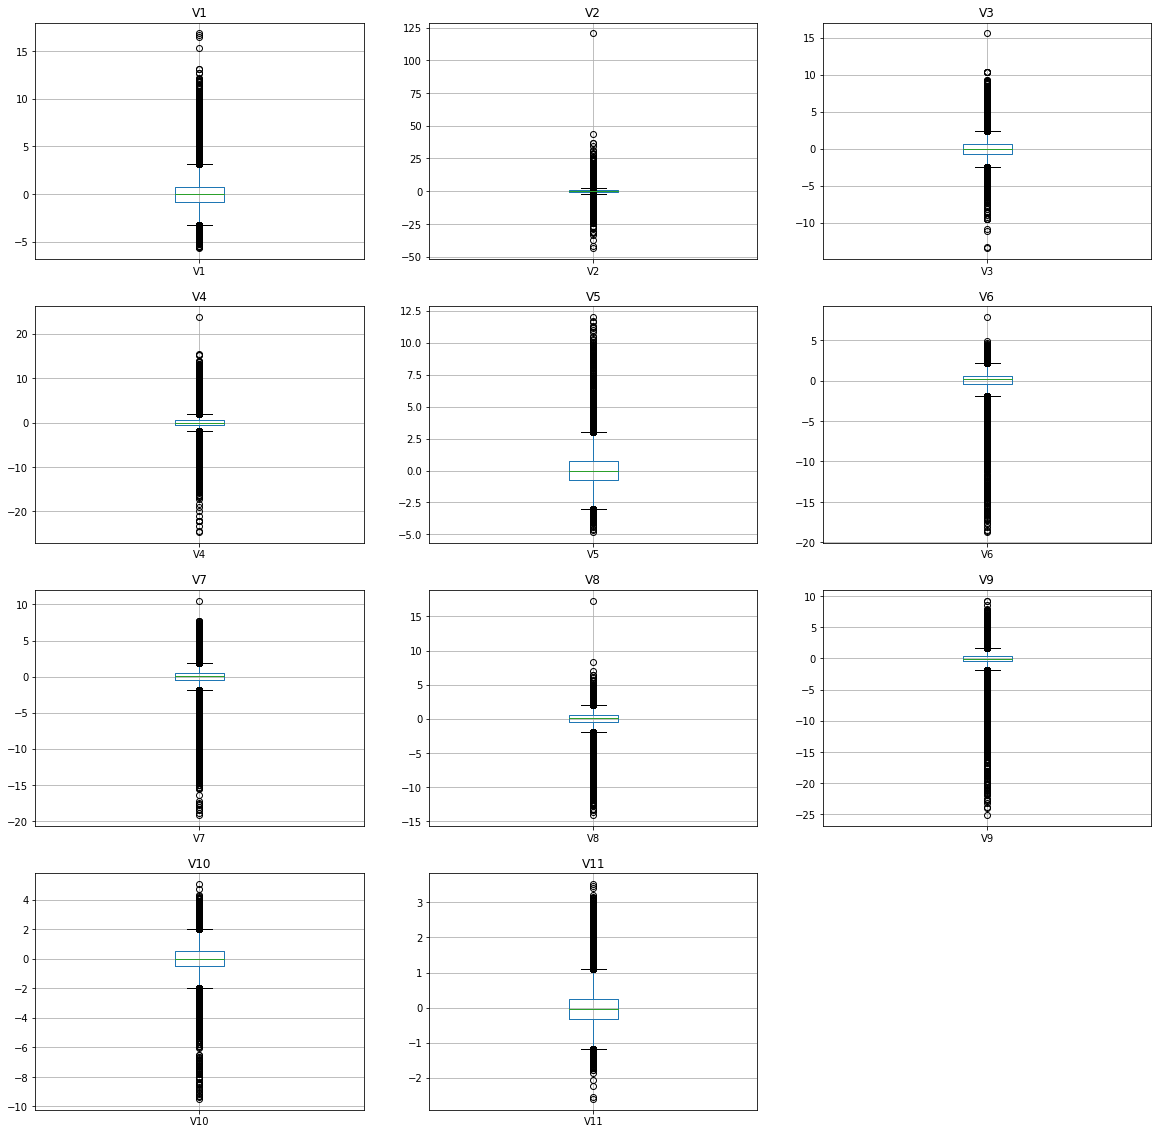

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

p = 1 # plot counter, starts in 1 to ignore id
plt.figure(figsize=(20,20)) # sets size for whole figure
for i in data:
    plt.subplot(4,3,p) # assigns subplot index
    plt.title(i)
    p = p + 1
    data.boxplot([i]) # calculates boxplot for the specified variable

## Algorithms

Link to some algorithms: https://machinelearningmastery.com/clustering-algorithms-with-python/

### 1. NAME 1

#### Description:

#### Implementation:

### 2. Name 2

#### Description:

#### Implementation:

## Experimental Design

Number of clusters:

## Results